In [1]:
import pandas as pd
import numpy as np

## Data Collection

In [2]:
from google.colab import drive

drive.mount('/content/drive')
data = pd.read_csv('/content/drive/MyDrive/Colab Notebooks/datasets/FER2013/fer2013.csv')

Mounted at /content/drive


## Data Preprocessing

In [3]:
def preprocess_images(data):
    images = []
    labels = data['emotion'].values

    for pixel_sequence in data['pixels']:
        single_image = np.fromstring(pixel_sequence, dtype=int, sep=' ')
        single_image = single_image.reshape(48, 48)
        images.append(single_image)

    images = np.array(images, dtype='float32')
    images = np.expand_dims(images, -1)  # Additional dimension for channels
    images /= 255.0  # Standardization (value between 0 and 1)

    return images, labels

In [4]:
images, labels = preprocess_images(data)
print(f"\nNumber of images in dataset: {len(images)}")


Number of images in dataset: 35887


In [5]:
from sklearn.model_selection import train_test_split

images1D = images.reshape(images.shape[0], -1)
X_train, X_test, y_train, y_test = train_test_split(images1D, labels, test_size=0.25, random_state=42)
X_train, X_val, y_train, y_val = train_test_split(X_train, y_train, test_size=0.2, random_state=42)

### SMOTE

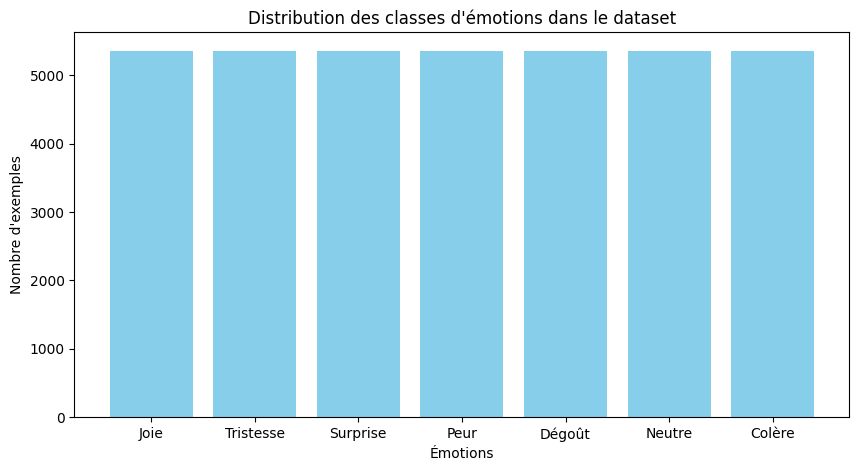

In [6]:
from imblearn.over_sampling import SMOTE
from collections import Counter
from sklearn.utils import resample
import matplotlib.pyplot as plt

sm = SMOTE(random_state=42)
X_train_sm, y_train_sm = sm.fit_resample(X_train, y_train)

label_counts = Counter(y_train_sm)

emotions, counts = zip(*label_counts.items())

plt.figure(figsize=(10, 5))
plt.bar(emotions, counts, color='skyblue')
plt.xlabel('Émotions')
plt.ylabel('Nombre d\'exemples')
plt.title('Distribution des classes d\'émotions dans le dataset')
plt.xticks(emotions, ['Colère', 'Dégoût', 'Peur', 'Joie', 'Tristesse', 'Surprise', 'Neutre'])
plt.show()

In [7]:
from tensorflow.keras.utils import to_categorical

train_images = X_train_sm.reshape(-1 ,48, 48)
train_labels = to_categorical(y_train_sm, num_classes=7)
val_images = X_val.reshape(-1, 48, 48)
val_labels = to_categorical(y_val, num_classes=7)
test_images = X_test.reshape(-1, 48, 48)
test_labels = to_categorical(y_test, num_classes=7)

In [10]:
train_images = np.expand_dims(train_images, axis=-1)
val_images = np.expand_dims(val_images, axis=-1)
test_images = np.expand_dims(test_images, axis=-1)

## Construction of the Classification Model

In [12]:
from tensorflow.keras.models import Sequential
from tensorflow.keras.layers import Conv2D, MaxPooling2D, Flatten, Dense, Dropout

model = Sequential([
    Conv2D(32, (3, 3), activation='relu', input_shape=(48, 48, 1)),
    MaxPooling2D((2, 2)),
    Conv2D(64, (3, 3), activation='relu'),
    MaxPooling2D((2, 2)),
    Conv2D(128, (3, 3), activation='relu'),
    MaxPooling2D((2, 2)),
    Flatten(),
    Dense(1024, activation='relu'),
    Dropout(0.5),
    Dense(7, activation='softmax')  # 7 is the number of expression classes in FER-2013
])

model.compile(optimizer='adam', loss='categorical_crossentropy', metrics=['accuracy'])

/usr/local/lib/python3.10/dist-packages/keras/src/layers/convolutional/base_conv.py:107: UserWarning: Do not pass an `input_shape`/`input_dim` argument to a layer. When using Sequential models, prefer using an `Input(shape)` object as the first layer in the model instead.
  super().__init__(activity_regularizer=activity_regularizer, **kwargs)


## Model Training

In [13]:
history = model.fit(train_images, train_labels, epochs=50, batch_size=64, validation_data=(val_images, val_labels))

Epoch 1/50
587/587 ━━━━━━━━━━━━━━━━━━━━ 16s 15ms/step - accuracy: 0.2703 - loss: 1.7943 - val_accuracy: 0.4555 - val_loss: 1.4303
Epoch 2/50
587/587 ━━━━━━━━━━━━━━━━━━━━ 9s 6ms/step - accuracy: 0.5099 - loss: 1.2982 - val_accuracy: 0.4925 - val_loss: 1.3229
Epoch 3/50
587/587 ━━━━━━━━━━━━━━━━━━━━ 4s 6ms/step - accuracy: 0.5875 - loss: 1.0921 - val_accuracy: 0.5064 - val_loss: 1.3344
Epoch 4/50
587/587 ━━━━━━━━━━━━━━━━━━━━ 6s 7ms/step - accuracy: 0.6368 - loss: 0.9599 - val_accuracy: 0.5261 - val_loss: 1.2535
Epoch 5/50
587/587 ━━━━━━━━━━━━━━━━━━━━ 5s 7ms/step - accuracy: 0.6828 - loss: 0.8479 - val_accuracy: 0.5363 - val_loss: 1.2598
Epoch 6/50
587/587 ━━━━━━━━━━━━━━━━━━━━ 5s 7ms/step - accuracy: 0.7230 - loss: 0.7534 - val_accuracy: 0.5569 - val_loss: 1.2739
Epoch 7/50
587/587 ━━━━━━━━━━━━━━━━━━━━ 5s 6ms/step - accuracy: 0.7640 - loss: 0.6526 - val_accuracy: 0.5564 - val_loss: 1.2979
Epoch 8/50
587/587 ━━━━━━━━━━━━━━━━━━━━ 4s 6ms/step - accuracy: 0.7964 - loss: 0.5667 - val_accuracy: 

## Model evaluation

In [16]:
test_loss, test_accuracy = model.evaluate(test_images, test_labels)

print(f"Test Loss: {test_loss}")
print(f"Test Accuracy: {test_accuracy}")


281/281 ━━━━━━━━━━━━━━━━━━━━ 2s 4ms/step - accuracy: 0.5514 - loss: 3.3670
Test Loss: 3.309556484222412
Test Accuracy: 0.5555059909820557


## Performance Metrics

In [19]:
from sklearn.metrics import confusion_matrix, classification_report

predicted_labels = model.predict(test_images)
predicted_labels = np.argmax(predicted_labels, axis=1)

conf_matrix = confusion_matrix(test_labels.argmax(axis=1), predicted_labels)

print("Confusion Matrix :")
print(conf_matrix)

class_report = classification_report(test_labels.argmax(axis=1), predicted_labels, target_names=['Colère', 'Dégoût', 'Peur', 'Joie', 'Tristesse', 'Surprise', 'Neutre'])
print("Classification Report :")
print(class_report)


281/281 ━━━━━━━━━━━━━━━━━━━━ 0s 1ms/step
Confusion Matrix :
[[ 468   12  165  137  220   67  166]
 [  24   64   11    5   17    6    3]
 [ 114    6  522  115  255  146  146]
 [  66    5   82 1704  152   62  177]
 [ 128   10  213  152  662   50  284]
 [  26    0   90   64   33  737   40]
 [  84    5  151  198  248   53  827]]
Classification Report :
              precision    recall  f1-score   support

      Colère       0.51      0.38      0.44      1235
      Dégoût       0.63      0.49      0.55       130
        Peur       0.42      0.40      0.41      1304
        Joie       0.72      0.76      0.74      2248
   Tristesse       0.42      0.44      0.43      1499
    Surprise       0.66      0.74      0.70       990
      Neutre       0.50      0.53      0.52      1566

    accuracy                           0.56      8972
   macro avg       0.55      0.53      0.54      8972
weighted avg       0.55      0.56      0.55      8972

